In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec

In [2]:
json_para = [
    ex for i in range (12) for ex in  json.load(open("../data/MultiNews_data_tfidf_30_paddle_full_paragraph/train/MultiNews.30.train.%s.json" % (i), encoding="utf-8"))
]

In [3]:
json_sent = [
    ex for i in range (12) for ex in  json.load(open("../data/MultiNews_data_tfidf_30_paddle_full_sentence/train/MultiNews.30.train.%s.json" % (i), encoding="utf-8"))
]

In [4]:
len(json_para),len(json_sent)

(44692, 44692)

In [5]:
max_num_sent = np.max([len(ex["sim_graph"]) for ex in json_sent])

In [6]:
max_num_sent

154

In [7]:
para_weights = np.empty(shape=[len(json_para),30,30])
para_weights[:] = np.nan
sent_weights = np.empty(shape=[len(json_para),max_num_sent,max_num_sent])
sent_weights[:] = np.nan

para_weight_list = []
sent_weight_list = []

para_mean_array = np.zeros(shape=[len(json_para)])
sent_mean_array = np.zeros(shape=[len(json_para)])

para_sum_array = np.zeros(shape=[len(json_para)])
sent_sum_array = np.zeros(shape=[len(json_para)])

para_weight_list_mapping = []
sent_weight_list_mapping = []

sentence_length = []
paragraph_length = []

tmp_length_array = []


for i in range(len(json_para)):
    para_weight_list.extend(np.array(json_para[i]["sim_graph"]).reshape(-1,))
    sent_weight_list.extend(np.array(json_sent[i]["sim_graph"]).reshape(-1,))
    
    
    sentence_length.extend([len(sent) for sent in json_sent[i]["src"]])
    paragraph_length.extend([len(para) for para in json_para[i]["src"]])
    
    
    para_weights[i,:len(json_para[i]["sim_graph"]),:len(json_para[i]["sim_graph"])] = json_para[i]["sim_graph"]
    sent_weights[i,:len(json_sent[i]["sim_graph"]),:len(json_sent[i]["sim_graph"])] = json_sent[i]["sim_graph"]
        
    
    length_array = []
    for ex in json_para[i]["src"]:
        length = 0
        tmp = np.unique(ex, return_counts=True)[1][np.unique(ex, return_counts=True)[0] == 11]

        if len(tmp) > 0:
            length += tmp[0]

        if ex[-1] != 11:
            length += 1


        length_array.append(length)
    
    tmp_length_array.extend(length_array)
    length_array = np.cumsum([0] + length_array)
    for j in range(len(length_array)-1):
        
        tmp = sent_weights[i,length_array[j]:length_array[j+1],:]
        mean_sent = np.nanmean(tmp,axis=1)
        sent_weight_list_mapping.append(mean_sent)
        
        
        para_value = np.nanmean(para_weights[i,j,:])
        para_weight_list_mapping.append(np.repeat(para_value,len(mean_sent)))
        





<ipython-input-7-8d3b6fa7c4d6>:56: RuntimeWarning: Mean of empty slice
  mean_sent = np.nanmean(tmp,axis=1)


In [8]:
np.mean(tmp_length_array)

1.8405020323677352

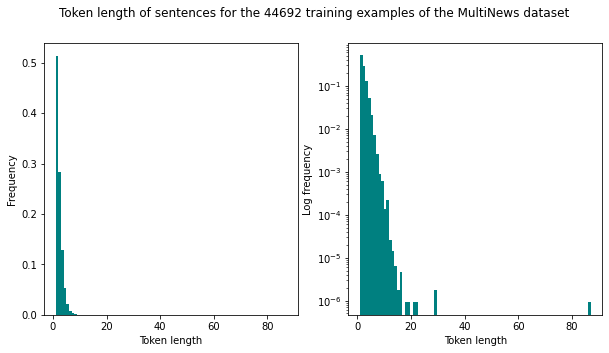

In [33]:
spec = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Token length of sentences for the 44692 training examples of the MultiNews dataset")
fig.add_subplot(spec[0])
_=plt.hist(tmp_length_array, 87, density=True, color="teal", label="Sentences")
plt.xlabel("Token length")
plt.ylabel("Frequency")
fig.add_subplot(spec[1])
_=plt.hist(tmp_length_array, 87, density=True, color="teal", label="Sentences")
plt.yscale("log")
plt.xlabel("Token length")
plt.ylabel("Log frequency")

plt.savefig("./images/length.pdf", format="pdf", facecolor="white")


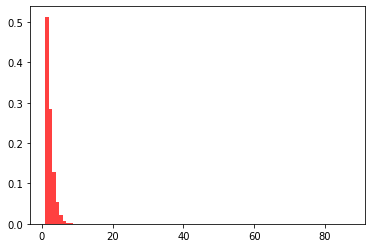

In [11]:
_ = plt.hist(tmp_length_array, 87, density=True, facecolor='r', alpha=0.75, label="Sentences")

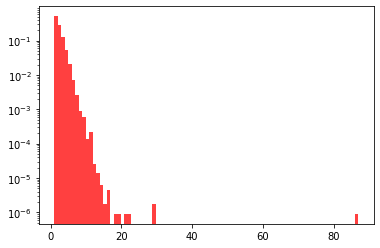

In [12]:
_ = plt.hist(tmp_length_array, 87, density=True, facecolor='r', alpha=0.75, label="Sentences")
plt.yscale("log")

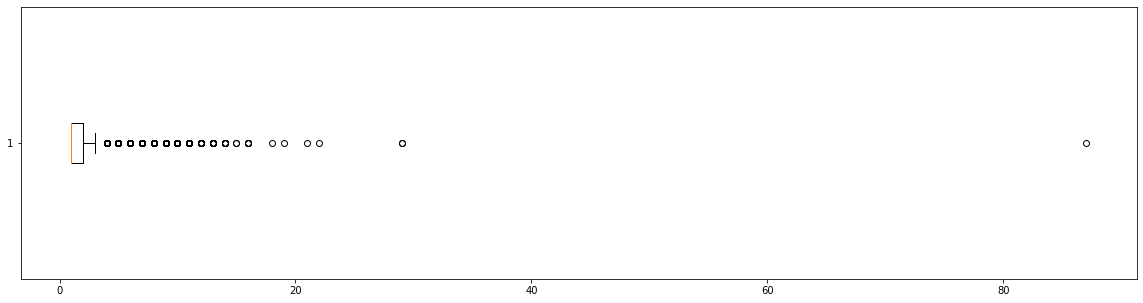

In [13]:
fig = plt.figure(figsize=(20,5))
b = plt.boxplot(tmp_length_array, vert=False)

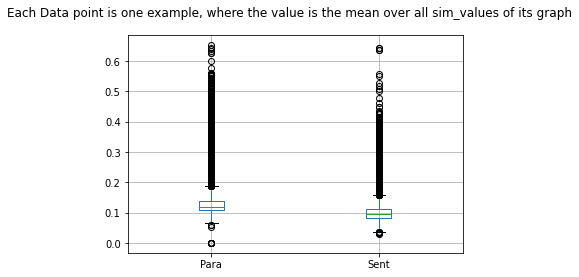

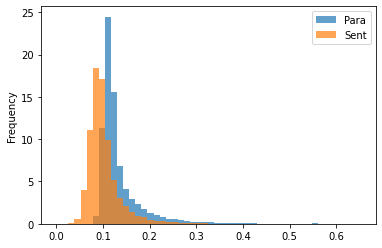

In [28]:
df = pd.DataFrame(np.stack([np.nanmean(para_weights,axis=(1,2)), np.nanmean(sent_weights,axis=(1,2))],axis=1), columns=['Para', 'Sent'] )

plt.figure()
plt.suptitle("Each Data point is one example, where the value is the mean over all sim_values of its graph")
#plt.title("Each Data point is one example, where the value is the mean over all sim_values of its graph")
df.boxplot()
display()
df.plot.hist(bins=50, alpha=0.7, density=True)
display()


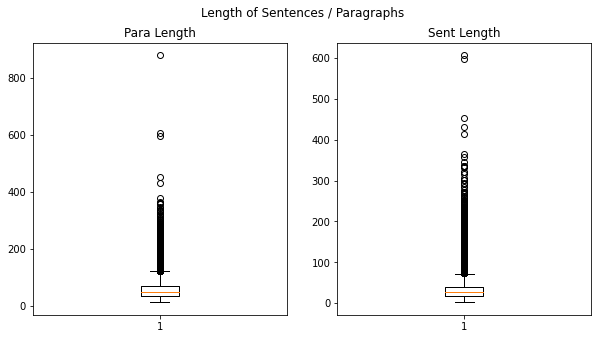

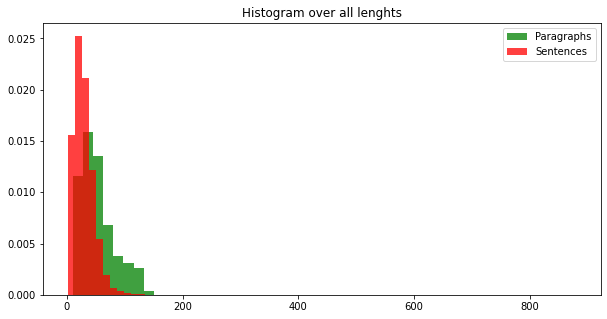

In [15]:
fig1, ax1 = plt.subplots(1,2, figsize=(10,5))

plt.suptitle("Length of Sentences / Paragraphs")
ax1[0].set_title('Para Length')
ax1[0].boxplot(paragraph_length)

ax1[1].set_title('Sent Length')
ax1[1].boxplot(sentence_length)

plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(paragraph_length, 50, density=True, facecolor='g', alpha=0.75, label="Paragraphs")

n, bins, patches = plt.hist(sentence_length, 50, density=True, facecolor='r', alpha=0.75, label="Sentences")

plt.title("Histogram over all lenghts")
plt.legend()
display()

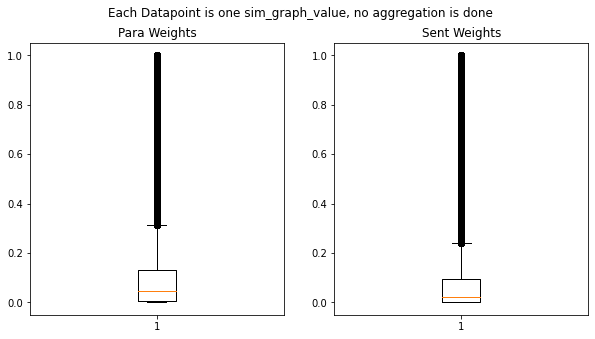

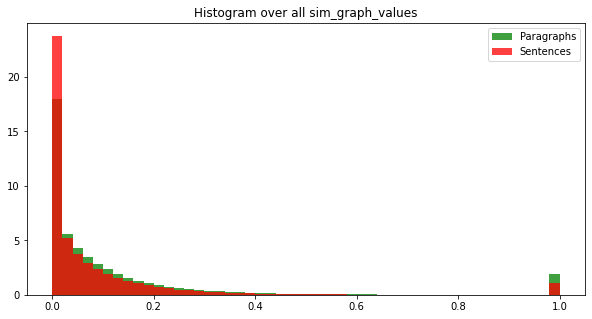

In [16]:
fig1, ax1 = plt.subplots(1,2, figsize=(10,5))

plt.suptitle("Each Datapoint is one sim_graph_value, no aggregation is done")
ax1[0].set_title('Para Weights')
ax1[0].boxplot(para_weight_list)

ax1[1].set_title('Sent Weights')
ax1[1].boxplot(sent_weight_list)

plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(para_weight_list, 50, density=True, facecolor='g', alpha=0.75, label="Paragraphs")

n, bins, patches = plt.hist(sent_weight_list, 50, density=True, facecolor='r', alpha=0.75, label="Sentences")

plt.title("Histogram over all sim_graph_values")
plt.legend()
display()

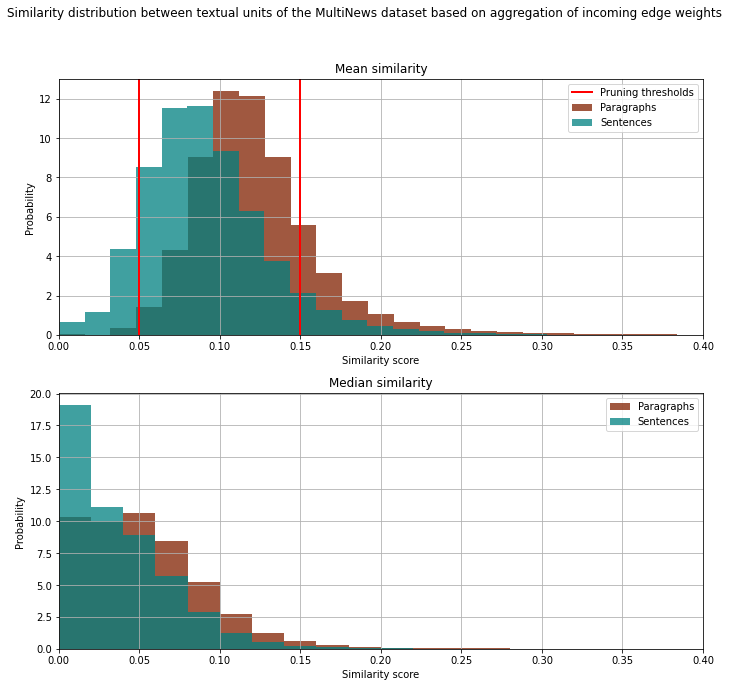

In [55]:
functions_to_apply = [{"name": "Mean similarity", "fun": np.nanmean},  {"name": "Median similarity", "fun": np.nanmedian}] #{"name": "Sum", "fun": np.nansum},
# 0.05 & 0.15
fig, axs = plt.subplots(len(functions_to_apply),1,figsize=(10,10))


para_mask = np.all(np.isnan(para_weights), axis=2)
tmp_para_weights = para_weights[~para_mask]

sent_mask = np.all(np.isnan(sent_weights), axis=2)
tmp_sent_weights = sent_weights[~sent_mask]

for i,fun in enumerate(functions_to_apply):

    
    n, bins, patches = axs[i].hist(fun["fun"](tmp_para_weights,axis=1).reshape(-1,), 50, density=True, facecolor='#802000', alpha=0.75, label="Paragraphs")
    n, bins, patches = axs[i].hist(fun["fun"](tmp_sent_weights,axis=1).reshape(-1,), 50, density=True, facecolor='teal', alpha=0.75, label="Sentences")

    #axs[i,1].boxplot([fun["fun"](tmp_para_weights,axis=1).reshape(-1,), fun["fun"](tmp_sent_weights,axis=1).reshape(-1,)])
    
    #axs[i,1].set_xticklabels(["Para", "Sent"])

  
    axs[i].set_xlim(0, 0.4)
    axs[i].set_xlabel('Similarity score')
    axs[i].set_ylabel('Probability')
    axs[i].set_title(fun["name"])
    #axs[i].set_text(60, .025, r'$\mu=100,\ \sigma=15$')
    #plt.xlim(0, 0.4)
    #plt.ylim(0, 0.03)
    
    if i==0:
        #axs[i].axvspan(0.05, 0.15, alpha=0.25, color='#800040')
        axs[i].axvline(0.05, 0, lw=2, color='r')
        axs[i].axvline(0.15, 0, lw=2, color='r', label= "Pruning thresholds")
    
    axs[i].legend()   

    axs[i].grid(True)  

    
    
plt.suptitle("Similarity distribution between textual units of the MultiNews dataset based on aggregation of incoming edge weights")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("./images/agg_information_sentence_paragraph.pdf")
plt.savefig("./images/agg_information_sentence_paragraph.png", dpi=200)

plt.show()

In [18]:
sent_tmp= np.nanmean(tmp_sent_weights, axis=1).reshape(-1,)

sent_tmp[(sent_tmp > 0.18) | (sent_tmp < 0.05)].shape[0] / sent_tmp.shape[0]

0.14060130009517044

[0.0, 0.1801911967588549]

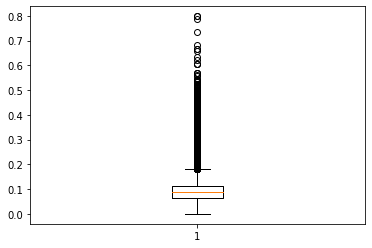

In [19]:
B = plt.boxplot(np.nanmean(tmp_sent_weights,axis=1).reshape(-1,))
[item.get_ydata()[1] for item in B['whiskers']]

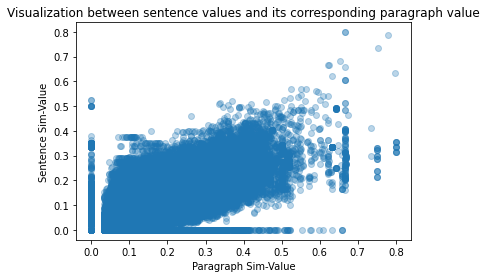

In [20]:
plt.figure()
plt.title("Visualization between sentence values and its corresponding paragraph value")
plt.scatter([value for para in para_weight_list_mapping for value in para], [value for sent in sent_weight_list_mapping for value in sent], alpha=0.3)
plt.xlabel("Paragraph Sim-Value")
plt.ylabel("Sentence Sim-Value")
display()

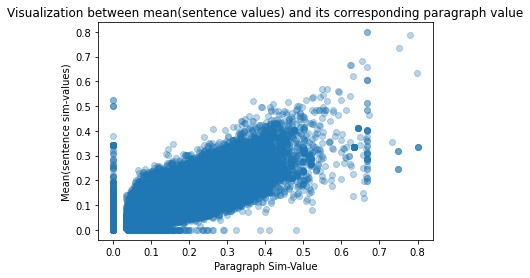

In [21]:
plt.figure()
plt.title("Visualization between mean(sentence values) and its corresponding paragraph value")
plt.scatter([np.mean(para) for para in para_weight_list_mapping], [np.mean(sent) for sent in sent_weight_list_mapping], alpha=0.3)
plt.xlabel("Paragraph Sim-Value")
plt.ylabel("Mean(sentence sim-values)")
display()

In [22]:
pd.DataFrame(np.stack([[np.mean(para) for para in para_weight_list_mapping], [np.mean(sent) for sent in sent_weight_list_mapping]],axis=1) , columns=["para","sent"]).corr()

,para,sent
para,1.000000,0.743395
sent,0.743395,1.000000


In [23]:
pd.DataFrame(np.stack([[value for para in para_weight_list_mapping for value in para], [value for sent in sent_weight_list_mapping for value in sent]],axis=1) , columns=["para","sent"]).corr()

,para,sent
para,1.000000,0.600608
sent,0.600608,1.000000
